In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 9.0 MB/s eta 0:00:00


In [ ]:
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import pytz
import pickle
import pandas as pd
from tqdm import tqdm
import random
import re
import emoji
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Q9.1

In [ ]:
def calculate_averages(file_path):
    total_tweets = 0
    total_followers = 0
    total_retweets = 0
    start_time = float('inf')
    end_time = 0

    with open(file_path, 'r') as file:
        for line in file:
            tweet = json.loads(line)
            total_tweets += 1
            total_followers += tweet['author']['followers']
            total_retweets += tweet['metrics']['citations']['total']

            tweet_time = tweet['citation_date']
            if tweet_time < start_time:
                start_time = tweet_time
            if tweet_time > end_time:
                end_time = tweet_time

    start_time = datetime.fromtimestamp(start_time)
    end_time = datetime.fromtimestamp(end_time)

    duration_hours = (end_time - start_time).total_seconds() / 3600

    average_tweets_per_hour = total_tweets / duration_hours if duration_hours > 0 else float('inf')
    average_followers_per_tweet = total_followers / total_tweets if total_tweets > 0 else 0
    average_retweets_per_tweet = total_retweets / total_tweets if total_tweets > 0 else 0

    return average_tweets_per_hour, average_followers_per_tweet, average_retweets_per_tweet

directory_path = '/content/drive/MyDrive/ECE219/HW4/tweet_data'

for file_name in os.listdir(directory_path):
    if file_name.startswith('tweets_') and file_name.endswith('.txt'):
        file_path = os.path.join(directory_path, file_name)
        averages = calculate_averages(file_path)
        print(f'File: {file_name}')
        print(f'Average number of tweets per hour: {averages[0]:.2f}')
        print(f'Average number of followers per tweet: {averages[1]:.2f}')
        print(f'Average number of retweets per tweet: {averages[2]:.2f}')
        print('---')


File: tweets_#nfl.txt
Average number of tweets per hour: 397.02
Average number of followers per tweet: 4662.38
Average number of retweets per tweet: 1.53
---
File: tweets_#superbowl.txt
Average number of tweets per hour: 2072.12
Average number of followers per tweet: 8814.97
Average number of retweets per tweet: 2.39
---
File: tweets_#sb49.txt
Average number of tweets per hour: 1276.86
Average number of followers per tweet: 10374.16
Average number of retweets per tweet: 2.53
---
File: tweets_#patriots.txt
Average number of tweets per hour: 750.89
Average number of followers per tweet: 3280.46
Average number of retweets per tweet: 1.79
---
File: tweets_#gohawks.txt
Average number of tweets per hour: 292.49
Average number of followers per tweet: 2217.92
Average number of retweets per tweet: 2.01
---
File: tweets_#gopatriots.txt
Average number of tweets per hour: 40.95
Average number of followers per tweet: 1427.25
Average number of retweets per tweet: 1.41
---


# Q9.2

In [ ]:
def to_pst_time(unix_time):
    utc_time = datetime.fromtimestamp(unix_time, pytz.utc)
    pst_time = utc_time.astimezone(pytz.timezone('America/Los_Angeles'))
    return pst_time

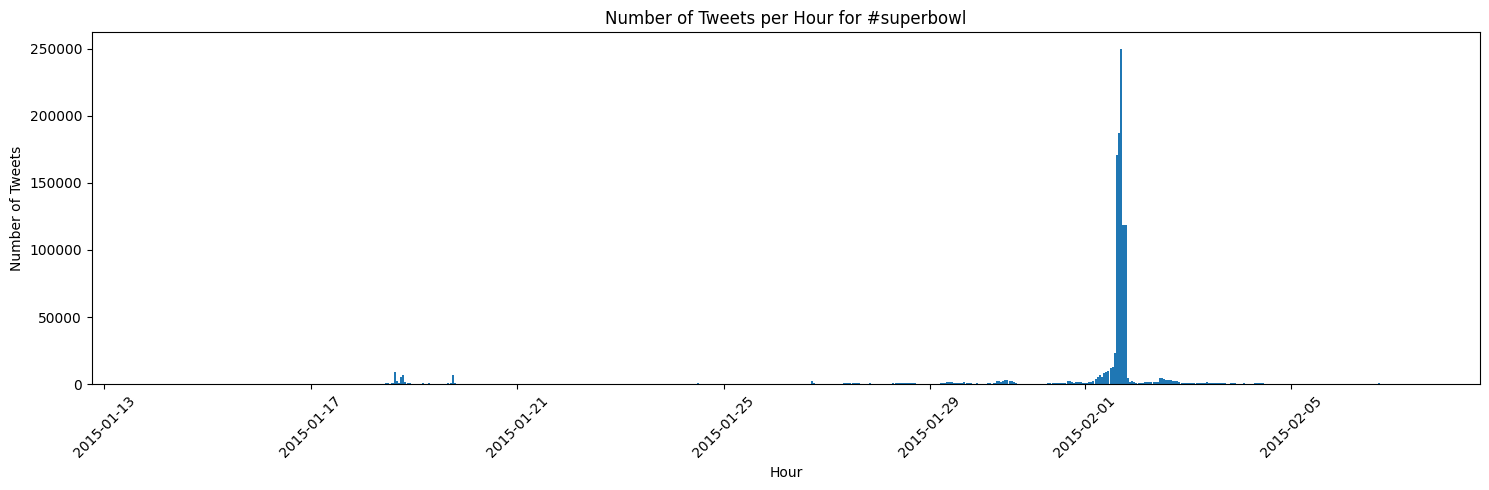

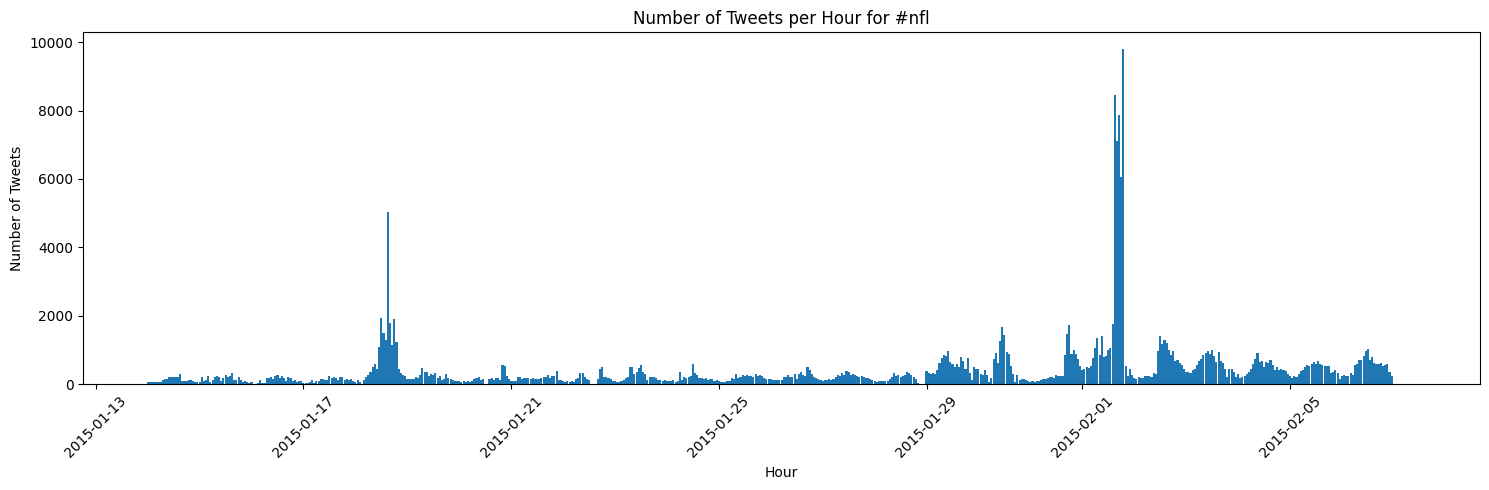

In [ ]:
def count_tweets_per_hour(file_path):
    tweet_counts = Counter()

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            tweet = json.loads(line)
            tweet_time = to_pst_time(tweet['citation_date'])
            tweet_time = tweet_time.replace(minute=0, second=0, microsecond=0)
            tweet_counts[tweet_time] += 1

    return tweet_counts

def plot_tweets_per_hour(tweet_counts, hashtag):
    times = sorted(tweet_counts.keys())
    counts = [tweet_counts[time] for time in times]

    plt.figure(figsize=(15,5))
    plt.bar(times, counts, width=0.04, align='center')
    plt.title(f'Number of Tweets per Hour for {hashtag}')
    plt.xlabel('Hour')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

hashtags = ['#superbowl', '#nfl']
for hashtag in hashtags:
    file_path = f'/content/drive/MyDrive/ECE219/HW4/tweet_data/tweets_{hashtag}.txt'
    tweet_counts = count_tweets_per_hour(file_path)
    plot_tweets_per_hour(tweet_counts, hashtag)


# Q10

## Library of Prediction Tasks given a tweet: Hashtag Prediction

## Explore Data

In [ ]:
file_name = "tweets_#gopatriots.txt"
hashtag = file_name.split('_')[1].split('.')[0].lower()
file_path = "/content/drive/MyDrive/ECE219/HW4/tweet_data/tweets_#gopatriots.txt"

with open(file_path, 'r', encoding='utf-8') as file:
  count = 0
  for line in file:
      count += 1
      if count == 3:
        break
      tweet = json.loads(line)
      print(f'{tweet.keys()} \n')
      for k in tweet.keys():
        if k == 'citation_date':
          print(f'{k} = {tweet_time} \n')
        elif k == 'firstpost_date':
          tweet_time = to_pst_time(tweet['firstpost_date'])
          print(f'{k} = {tweet_time} \n')
        elif isinstance(tweet[k], dict):
          print(f'{k}:')
          for subk in tweet[k].keys():
            print(f'{subk} = {tweet[k][subk]}')
          print('\n')
        else:
          print(f'{k} = {tweet[k]} \n')
      print('---------------------------------------------------------------------')


dict_keys(['firstpost_date', 'title', 'url', 'tweet', 'author', 'original_author', 'citation_date', 'metrics', 'highlight', 'type', 'citation_url']) 

firstpost_date = 2015-01-09 12:30:45-08:00 

title = LeGarrette Blount does the Ray Lewis Dance #ThrowbackThursday https://t.co/F5FX5KVmdX
Hope to see it at least 3 times tomorrow. 
#GoPatriots 

url = http://twitter.com/NESportsFan1106/status/553650101105606656 

tweet:
contributors = None
truncated = False
text = LeGarrette Blount does the Ray Lewis Dance #ThrowbackThursday https://t.co/F5FX5KVmdX
Hope to see it at least 3 times tomorrow. 
#GoPatriots
in_reply_to_status_id = None
id = 553650101105606656
favorite_count = 0
source = <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
retweeted = False
coordinates = None
timestamp_ms = 1420835445082
entities = {'symbols': [], 'user_mentions': [], 'trends': [], 'hashtags': [{'indices': [43, 61], 'text': 'ThrowbackThursday'}, {'indices': [129, 140], 'text': 

In [ ]:
directory_path = '/content/drive/MyDrive/ECE219/HW4/tweet_data'

for file_name in os.listdir(directory_path):
    if file_name.startswith('tweets_') and file_name.endswith('.txt'):
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'r', encoding='utf-8') as file:
            total_lines = sum( 1 for line in file)
            print(f'{file_name} has {total_lines}')

tweets_#nfl.txt has 233022
tweets_#superbowl.txt has 1213813
tweets_#sb49.txt has 743649
tweets_#patriots.txt has 440621
tweets_#gohawks.txt has 169122
tweets_#gopatriots.txt has 23511


### Each hashtag has very different number of tweets.Since the data is unbalanced, we subsample the data by loading each file with smallest tweet number in a file, which is 23511.

In [ ]:
df = pd.DataFrame(columns=['post_time', 'tweet', 'hashtag'])

directory_path = '/content/drive/MyDrive/ECE219/HW4/tweet_data'

for file_name in os.listdir(directory_path):
    if file_name.startswith('tweets_') and file_name.endswith('.txt'):
        hashtag = file_name.split('_')[1].split('.')[0].lower()
        file_path = os.path.join(directory_path, file_name)
        # file_name = "tweets_#superbowl.txt"
        # file_path = "/content/drive/MyDrive/ECE219/HW4/tweet_data/" + file_name

        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            random.shuffle(lines)
            total_lines = len(lines)
            count = 0
            for line in tqdm(lines, total = min(total_lines,23511)):
                count += 1
                if count > 23511:
                    break
                tweet = json.loads(line)

                post_time = tweet['citation_date']
                tweet_text = tweet['tweet']['text']

                new_row = pd.DataFrame({
                    'post_time': [post_time],
                    'tweet': [tweet_text],
                    'hashtag': [hashtag]
                })

                df = pd.concat([df, new_row], ignore_index=True)

df



100%|██████████| 23511/23511 [01:40<00:00, 233.93it/s]


,post_time,tweet,hashtag
0,1422846379,Security does not want us on the field #SB49 #...,#nfl
1,1423272069,#Original #Autograph BRENT JONES AUTOGRAPHED/S...,#nfl
2,1422771793,#NFL #SuperBowlXLIX http://t.co/7Y10A3A5Z9 via...,#nfl
3,1421631610,I sure hope it's the #Seahawks and #Patriots i...,#nfl
4,1422538922,Brandon Browner's perspective on coaches http:...,#nfl
...,...,...,...
141061,1422829214,#GoPatriots http://t.co/T4FmVnwA57,#gopatriots
141062,1422842790,@DonnieWahlberg #AintOverUntilTheFatGirlSing! ...,#gopatriots
141063,1422825977,RT durgesh_4: Bring it home boys. #patriots #s...,#gopatriots
141064,1421610145,@Chicagoslim1999 @hoegaarden321 certainly have...,#gopatriots


In [ ]:
# Filter the DataFrame to only include the duplicate rows based on 'tweet' and 'post_time'
duplicate_rows = df[df.duplicated(subset=['tweet', 'post_time'], keep=False)]

print(duplicate_rows)


         post_time                                              tweet  \
2       1422771793  #NFL #SuperBowlXLIX http://t.co/7Y10A3A5Z9 via...   
9       1421633285                Gronk!!!!!!! #Patriots #NFLPlayoffs   
63      1422837546  @FoxNews NFL #SuperBowLiveStream2015 Game #Sup...   
68      1422846563  Interception! Nail in the coffin!  #Spurs #Pat...   
92      1422842251  #MiRitualEs #GoPatriots #NFL @AztecaDeportes.....   
...            ...                                                ...   
140918  1422846532                 #GoPatriots #PatriotsWIN #Patriots   
140965  1422838155  TOUCHDOWN GRONK GO PATRIOTS!!!! #SBXLIX #gopat...   
140968  1422845355      Bradyyyyy remontando!! #GoPatriots #superbowl   
140974  1422846453  Typical @Seahawks can't take they're beating l...   
141063  1422825977  RT durgesh_4: Bring it home boys. #patriots #s...   

            hashtag  
2              #nfl  
9              #nfl  
63             #nfl  
68             #nfl  
92           

###There are tweets that have more than one labels. To prevent duplicates, we delete these tweets and just focus on the ones with single hashtag.

In [ ]:
new_df = df.drop_duplicates(subset=['tweet', 'post_time'])

In [ ]:
new_df.to_csv('/content/drive/MyDrive/ECE219/HW4/tweet_subsample_nodup_data', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ECE219/HW4/tweet_subsample_nodup_data', lineterminator='\n')

In [ ]:
# Filter the DataFrame to only include the duplicate rows based on 'tweet' and 'post_time'
duplicate_rows = df[df.duplicated(subset=['tweet', 'post_time'], keep=False)]

print(duplicate_rows)


Empty DataFrame
Columns: [post_time, tweet, hashtag]
Index: []


In [ ]:
def replace_urls_with_placeholder(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '[link]', text)

def demojize_tweet(text):
    return emoji.demojize(text)

df['tweet'] = df['tweet'].fillna('')  # Fill NaN values with empty strings
df['tweet'] = df['tweet'].apply(replace_urls_with_placeholder)
df['tweet'] = df['tweet'].apply(demojize_tweet)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

inputs = tokenizer(list(df['tweet']),
                   padding=True,
                   truncation=True,
                   max_length=512,  # Ensure sequences are truncated to BERT's max length
                   return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Embedding

### We use TwHIN-BERT, a BERT model pretrained on tweets in multilanguage: https://huggingface.co/Twitter/twhin-bert-base BERT's ability to understand the context, its bidirectional nature, efficiency in transfer learning, and state-of-the-art performance across numerous NLP tasks make it a go-to choice. TwHIN-BERT is a great choice for working with Twitter data because it's specially trained for it, supports many languages, can handle messy data well, and understands the context of tweets deeply. All these qualities make it really good at figuring out hashtags from tweets, which helps a lot in analyzing social media and understanding what people are talking about on Twitter.








In [ ]:
bert_model = AutoModel.from_pretrained('Twitter/twhin-bert-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (distance_embedding): Embedding(1023, 64)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
df['hashtag_code'] = df['hashtag'].astype('category').cat.codes

hashtags_code_t = torch.tensor(df['hashtag_code'].values)

post_time_t = torch.tensor(df['post_time'].values).unsqueeze(1)

all_dataset = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'labels': hashtags_code_t,
    'post_time': post_time_t
}

all_dataset_t = TensorDataset(all_dataset['input_ids'], all_dataset['attention_mask'], all_dataset['labels'], all_dataset['post_time'])
all_data_loader = DataLoader(all_dataset_t, batch_size=8, shuffle=True)


###For embeddings, we concatenate the CLS token embedding with the average of other token embeddings, which finally gave us a feature vector of 768*2 dimensions. This approach is suggested by the author of TwHIN-BERT (https://arxiv.org/pdf/2209.07562.pdf). We also attached the unix time of tweets as another feature.

In [ ]:
bert_model.eval()  # Ensure the model is in evaluation mode
all_embeddings = []
all_labels = []
all_post_times = []

with torch.no_grad():
    for batch in tqdm(all_data_loader):
        input_ids, attention_mask, batch_labels, batch_post_times = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # Use pooled output as embeddings
        hidden_state = hidden_state.cpu().numpy()
        attention_mask = attention_mask.cpu().numpy()

        batch_embeddings = []

        for embedding,mask in zip(hidden_state, attention_mask):
          cls_embedding = embedding[mask==1,:][0,:] # extract cls token embedding
          token_embedding = embedding[mask==1,:][1:-2,:].mean(axis=0) # extract average token embeddings
          concat_embedding = np.concatenate((cls_embedding,token_embedding)) # concatenate
          # print(concat_embedding.shape)

          batch_embeddings.append(concat_embedding)

        # cls_embeddings = batch_embeddings[0,]
        all_embeddings.append(np.array(batch_embeddings))
        all_labels.append(batch_labels.numpy())
        all_post_times.append(batch_post_times.numpy())

svm_all_embeddings = np.vstack(all_embeddings)
svm_all_labels = np.concatenate(all_labels)
svm_all_post_times = np.concatenate(all_post_times).reshape(-1, 1)

# Normalize post_times
scaler = StandardScaler()
normalized_svm_all_post_times = scaler.fit_transform(svm_all_post_times) # normalize post time

combined_features_2 = np.hstack([normalized_svm_all_post_times, svm_all_embeddings]) # append post time

100%|██████████| 17462/17462 [08:24<00:00, 34.61it/s]


In [ ]:
combined_features_2

array([[ 0.51418404,  0.28309792,  0.39059228, ...,  0.04464252,
         0.0786689 , -0.12798363],
       [ 0.51598106,  0.28309792,  0.39059228, ...,  0.04464252,
         0.0786689 , -0.12798363],
       [ 0.52376403,  0.28309792,  0.39059228, ...,  0.04464252,
         0.0786689 , -0.12798363],
       ...,
       [ 0.0823295 ,  0.09153399,  0.74442261, ...,  0.01752592,
         0.16673514, -0.49639297],
       [ 0.14660571, -0.94917923,  0.24358241, ...,  0.35162538,
         0.07115292,  0.1401803 ],
       [ 0.45835546,  0.08652665,  0.38746494, ...,  0.20681639,
         0.32371157, -0.20904616]])

In [ ]:
with open('/content/drive/MyDrive/ECE219/HW4/combined_features_and_labels_2.pkl', 'wb') as f:
    pickle.dump({'features': combined_features_2, 'labels': svm_all_labels}, f)

In [ ]:
with open('/content/drive/MyDrive/ECE219/HW4/combined_features_and_labels_2.pkl', 'rb') as f:
    data = pickle.load(f)
    combined_features_2 = data['features']
    nn_all_labels = data['labels']

In [ ]:
# Split the train and test data
nn_train, nn_test, nn_labels_train, nn_labels_test = train_test_split(combined_features_2, nn_all_labels, test_size=0.2, random_state=42)

## Logistic Rregression

In [ ]:
scaler = StandardScaler() # standardize
nn_train_scaled = scaler.fit_transform(nn_train)
nn_test_scaled = scaler.transform(nn_test)

log_reg_classifier = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)
log_reg_classifier.fit(nn_train_scaled, nn_labels_train)

log_reg_preds = log_reg_classifier.predict(nn_test_scaled)

Logistic Regression Model Evaluation:
Accuracy: 0.8752
Precision: 0.8794
Recall: 0.8752
F1 Score: 0.8748


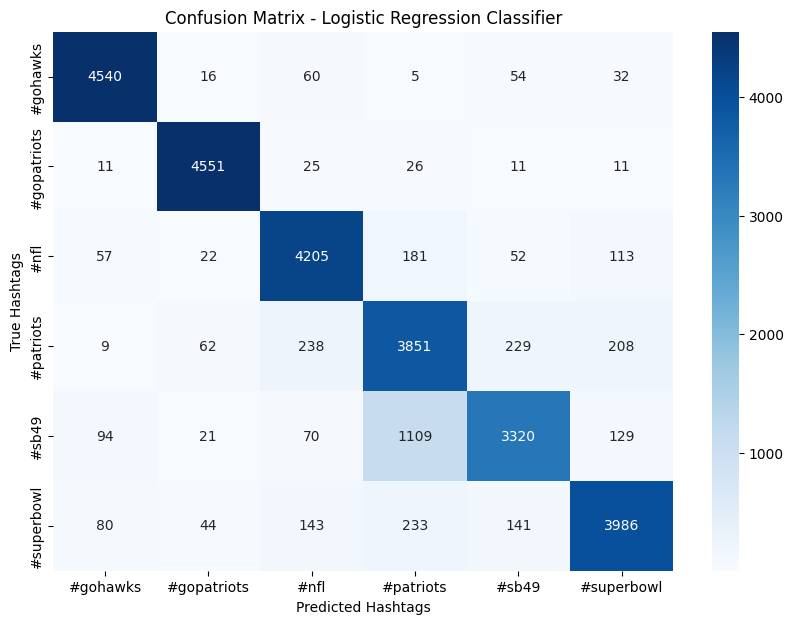

In [ ]:
# Evaluation
accuracy = accuracy_score(nn_labels_test, log_reg_preds)
precision = precision_score(nn_labels_test, log_reg_preds, average='weighted')
recall = recall_score(nn_labels_test, log_reg_preds, average='weighted')
f1 = f1_score(nn_labels_test, log_reg_preds, average='weighted')

print(f"Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
conf_matrix = confusion_matrix(nn_labels_test, log_reg_preds)

code_to_hashtag = dict(enumerate(df['hashtag'].astype('category').cat.categories))
axis_labels = [code_to_hashtag[code] for code in sorted(code_to_hashtag)]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.title("Confusion Matrix - Logistic Regression Classifier")
plt.xlabel("Predicted Hashtags")
plt.ylabel("True Hashtags")
plt.show()

###It is reasonable that the model predicts 1109 tweets with hashtag #sb49 to #patriots. New England Patriots are Super Bowl 49 Champions, so there will be many tweets with #sb49 and are talking about things related to patriots

## Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# Initialize and train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(nn_train_scaled, nn_labels_train)

# Make predictions on the test set
rf_preds = rf_classifier.predict(nn_test_scaled)


Random Forest Model Evaluation:
Accuracy: 0.7862
Precision: 0.7960
Recall: 0.7862
F1 Score: 0.7825


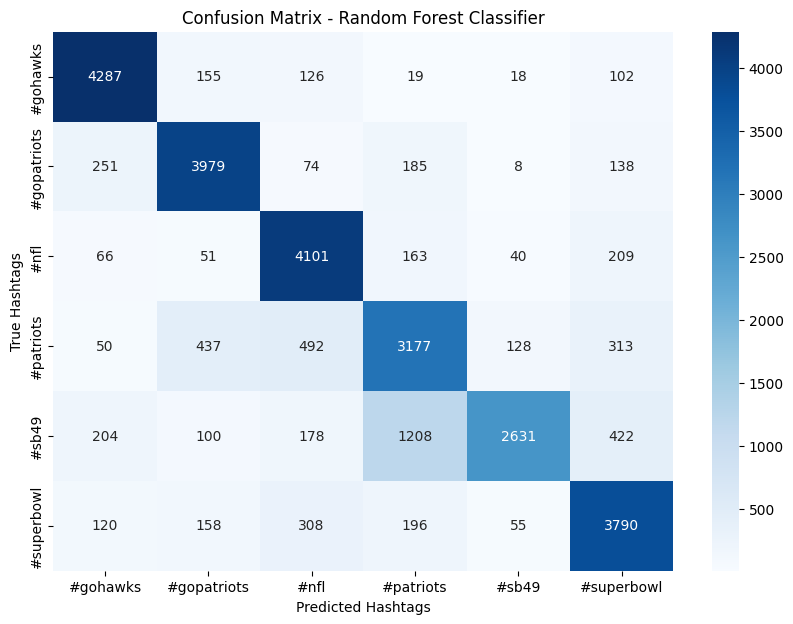

In [ ]:
# Evaluation
accuracy = accuracy_score(nn_labels_test, rf_preds)
precision = precision_score(nn_labels_test, rf_preds, average='weighted')
recall = recall_score(nn_labels_test, rf_preds, average='weighted')
f1 = f1_score(nn_labels_test, rf_preds, average='weighted')

print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
conf_matrix = confusion_matrix(nn_labels_test, rf_preds)
axis_labels = [code_to_hashtag[code] for code in sorted(code_to_hashtag.keys())]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Hashtags")
plt.ylabel("True Hashtags")
plt.show()

###It is obvious that Logistic Regression does a better job than Random Forest. The result of using Logistic Regression has higher average value of the 5 scores and better confusion matrix with darker color on the diagonal and lighter color in other entries.

###Since many tags have similar meanings, like #gopatriots and #patriots, #patriots and #sb49, let's use the same process to just focus on the tweets with hashtag of #gohawks and #gopatriots

# Try gohawks and gopatriots

In [ ]:
df_teams = df[df['hashtag'].isin(['#gopatriots', '#gohawks'])]

In [ ]:
df_teams = df_teams.reset_index(drop=True)

In [ ]:
df = df_teams

In [ ]:
def replace_urls_with_placeholder(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '[link]', text)

def demojize_tweet(text):
    return emoji.demojize(text)

df['tweet'] = df['tweet'].fillna('')  # Fill NaN values with empty strings
df['tweet'] = df['tweet'].apply(replace_urls_with_placeholder)
df['tweet'] = df['tweet'].apply(demojize_tweet)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

inputs = tokenizer(list(df['tweet']),
                   padding=True,
                   truncation=True,
                   max_length=512,
                   return_tensors="pt")

In [ ]:
df['hashtag_code'] = df['hashtag'].astype('category').cat.codes

hashtags_code_t = torch.tensor(df['hashtag_code'].values)

post_time_t = torch.tensor(df['post_time'].values).unsqueeze(1)

all_dataset = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'labels': hashtags_code_t,
    'post_time': post_time_t
}

all_dataset_t = TensorDataset(all_dataset['input_ids'], all_dataset['attention_mask'], all_dataset['labels'], all_dataset['post_time'])
all_data_loader = DataLoader(all_dataset_t, batch_size=8, shuffle=True)


In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
bert_model.eval()  # Ensure the model is in evaluation mode
all_embeddings = []
all_labels = []
all_post_times = []

with torch.no_grad():
    for batch in tqdm(all_data_loader):
        input_ids, attention_mask, batch_labels, batch_post_times = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # Use pooled output as embeddings
        hidden_state = hidden_state.cpu().numpy()
        attention_mask = attention_mask.cpu().numpy()

        batch_embeddings = []

        for embedding,mask in zip(hidden_state, attention_mask):
          cls_embedding = embedding[mask==1,:][0,:]
          token_embedding = embedding[mask==1,:][1:-2,:].mean(axis=0)
          concat_embedding = np.concatenate((cls_embedding,token_embedding))
          # print(concat_embedding.shape)

          batch_embeddings.append(concat_embedding)

        # cls_embeddings = batch_embeddings[0,]
        all_embeddings.append(np.array(batch_embeddings))
        all_labels.append(batch_labels.numpy())
        all_post_times.append(batch_post_times.numpy())

svm_all_embeddings = np.vstack(all_embeddings)
svm_all_labels = np.concatenate(all_labels)
svm_all_post_times = np.concatenate(all_post_times).reshape(-1, 1)

# Normalize post_times
scaler = StandardScaler()
normalized_svm_all_post_times = scaler.fit_transform(svm_all_post_times)

combined_features_2 = np.hstack([normalized_svm_all_post_times, svm_all_embeddings])

100%|██████████| 5803/5803 [08:05<00:00, 11.96it/s]


In [ ]:
with open('/content/drive/MyDrive/ECE219/HW4/combined_features_and_labels_2_teams.pkl', 'wb') as f:
    pickle.dump({'features': combined_features_2, 'labels': svm_all_labels}, f)

In [ ]:
with open('/content/drive/MyDrive/ECE219/HW4/combined_features_and_labels_2_teams.pkl', 'rb') as f:
    data = pickle.load(f)
    combined_features_2 = data['features']
    nn_all_labels = data['labels']

In [ ]:
nn_train, nn_test, nn_labels_train, nn_labels_test = train_test_split(combined_features_2, nn_all_labels, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
nn_train_scaled = scaler.fit_transform(nn_train)
nn_test_scaled = scaler.transform(nn_test)

log_reg_classifier = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)
log_reg_classifier.fit(nn_train_scaled, nn_labels_train)

log_reg_preds = log_reg_classifier.predict(nn_test_scaled)

Logistic Regression Model Evaluation:
Accuracy: 0.9973
Precision: 0.9973
Recall: 0.9973
F1 Score: 0.9973


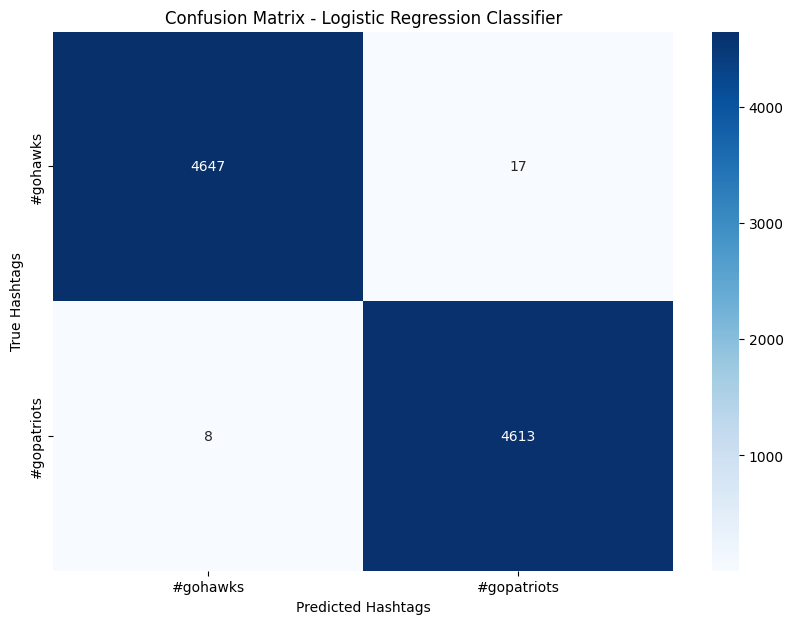

In [ ]:
# Evaluation
accuracy = accuracy_score(nn_labels_test, log_reg_preds)
precision = precision_score(nn_labels_test, log_reg_preds, average='weighted')
recall = recall_score(nn_labels_test, log_reg_preds, average='weighted')
f1 = f1_score(nn_labels_test, log_reg_preds, average='weighted')

print(f"Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
conf_matrix = confusion_matrix(nn_labels_test, log_reg_preds)

code_to_hashtag = dict(enumerate(df['hashtag'].astype('category').cat.categories))
axis_labels = [code_to_hashtag[code] for code in sorted(code_to_hashtag)]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.title("Confusion Matrix - Logistic Regression Classifier")
plt.xlabel("Predicted Hashtags")
plt.ylabel("True Hashtags")
plt.show()

In [ ]:
# Initialize and train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(nn_train_scaled, nn_labels_train)

# Make predictions on the test set
rf_preds = rf_classifier.predict(nn_test_scaled)


Random Forest Model Evaluation:
Accuracy: 0.9572
Precision: 0.9573
Recall: 0.9572
F1 Score: 0.9572


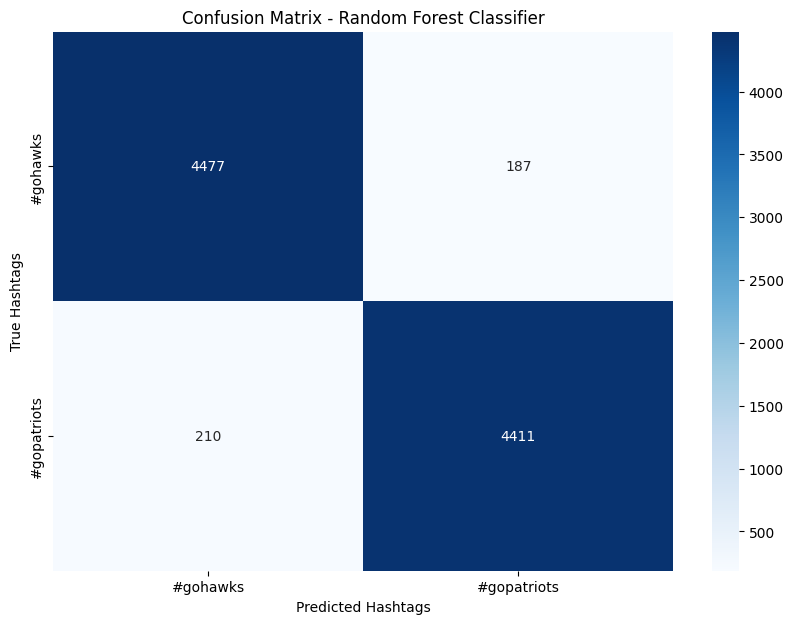

In [ ]:
# Evaluation
accuracy = accuracy_score(nn_labels_test, rf_preds)
precision = precision_score(nn_labels_test, rf_preds, average='weighted')
recall = recall_score(nn_labels_test, rf_preds, average='weighted')
f1 = f1_score(nn_labels_test, rf_preds, average='weighted')

print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
conf_matrix = confusion_matrix(nn_labels_test, rf_preds)
axis_labels = [code_to_hashtag[code] for code in sorted(code_to_hashtag.keys())]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Hashtags")
plt.ylabel("True Hashtags")
plt.show()

###Again, Logistic Regression does a better job than Random Forest. When we focus on these two tags, which means opponent, our model does a very good job with high 5 scores and good confusion matrix.

### Overall, logistic regression is better. This is sensible as features from BERT prove to be usually very robust for a variety of downstream tasks. For processing robust features, a simpler model can prevent potential overfitting.